In [38]:
from modeldef import *
import numpy as np
from scipy.optimize import minimize
import csv

class Place(FxnBlock):
    def __init__(self,flows, params):
        population = params[0]['pop']
#         self.extra = params[0]['extra']

# a is the contact rate after policy 2
# n is the increased number of medical staff per step in policy 1 
# v is the number of people who get vaccine per step in policy 2
# m is the default number of the medical staff 
# alpha is the threshold to triger policy 2 
# IR is the threshold  to triger policy 1 
# NMS is the  total number of the medical staff 
        self.a = params[0]['a']
        self.n = params[0]['n']
        self.v = params[0]['v']
        self.m = params[0]['m']
        self.alpha = params[0]['alpha']
        self.IR = params[0]['IR']
        self.NMS=0
        
        super().__init__(['Transport'],flows, {'Infected':population*2/10,'Susceptible':population*8/10,'Recovered':0.0})
        self.failrate=1e-5
        self.assoc_modes({'PL1':[1.0, [1,1,1], 1],'PL2':[1.0, [1,1,1], 1]})
                    
        
    def condfaults(self,time):
        # policy 1: if infect rate bigger than IR, add m medical staff per day,  infectious time will drop from 1.25 to 1.25/2
        # policy 2: if infected people bigger than alpha, contact rate will drop from 10 to a , susceptible people will get vaccine,v people/day
        if self.Infected/(self.Susceptible + self.Infected + self.Recovered)> self.alpha: 
            self.add_fault('PL2')
        if ( self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)) > self.IR:
            self.add_fault('PL1')            
        
            
    def behavior(self,time):
        if self.has_fault('PL1'):
          
            # c=(n+m)/m
            
            self.NMS+=self.n 
            self.c=(self.NMS+self.m)/(self.m)
            Infect_rate = self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)
            Recover_Rate = self.c * self.Infected / (1.25/2)    
            
            if time>self.time:
                self.Infected =self.Infected + 0.0001* ( Infect_rate - Recover_Rate)
                self.Susceptible = self.Susceptible- 0.0001* (Infect_rate - self.v)
                self.Recovered = self.Recovered + 0.0001* ( Recover_Rate + self.v)
        if self.has_fault('PL2'):
            self.a = self.alpha
            
            if time>self.time:
                self.Infected =self.Infected + 0.0001* ( Infect_rate - Recover_Rate)
                self.Susceptible = self.Susceptible- 0.0001* (Infect_rate - self.v)
                self.Recovered = self.Recovered + 0.0001* ( Recover_Rate + self.v)           
            
        # nominal state    
        Infect_rate= self.alpha * self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)
        Recover_Rate =  self.Infected / 1.25
        Leave_Rate = 0.5
       
        if time>self.time:
            self.Infected += 0.0001* (Infect_rate - Recover_Rate)
            self.Susceptible -= 0.0001* Infect_rate
            self.Recovered +=0.0001* Recover_Rate
#             if self.extra:
#                 self.Infected += 2
#                 self.Recovered -= 2
            # Arriving/Leaving
            self.Infected += self.Transport.In_I  - self.Transport.Out_I 
            self.Susceptible += self.Transport.In_S  - self.Transport.Out_S 
            self.Recovered += self.Transport.In_R - self.Transport.Out_R
            self.Transport.Stay_I  = self.Infected
            self.Transport.Stay_S  = self.Susceptible
            self.Transport.Stay_R  = self.Recovered
            

class Transit(FxnBlock):
    def __init__(self,flows):
        super().__init__(['T_Campus', 'T_Downtown', 'T_Living'],flows)
        self.failrate=1e-5
        self.assoc_modes({'na':[1.0, [1,1,1], 1]})
    def behavior(self,time):
        C_to_L = 0.1
        D_to_C = 0.1
        L_to_D = 0.1
        
        if time > self.time:
            self.T_Campus.Out_I = C_to_L * self.T_Campus.Stay_I
            self.T_Campus.Out_S = C_to_L * self.T_Campus.Stay_S
            self.T_Campus.Out_R = C_to_L * self.T_Campus.Stay_R 
            
            self.T_Downtown.Out_I = D_to_C * self.T_Downtown.Stay_I
            self.T_Downtown.Out_S = D_to_C * self.T_Downtown.Stay_S
            self.T_Downtown.Out_R  = D_to_C * self.T_Downtown.Stay_R 
            
            self.T_Living.Out_I = L_to_D * self.T_Living.Stay_I
            self.T_Living.Out_S = L_to_D * self.T_Living.Stay_S
            self.T_Living.Out_R  = L_to_D * self.T_Living.Stay_R          
            
            
            self.T_Downtown.In_I = self.T_Campus.Out_I
            self.T_Downtown.In_S = self.T_Campus.Out_S
            self.T_Downtown.In_R  = self.T_Campus.Out_R 
            
            self.T_Campus.In_I = self.T_Living.Out_I
            self.T_Campus.In_S = self.T_Living.Out_S
            self.T_Campus.In_R  = self.T_Living.Out_R  
            
            self.T_Living.In_I = self.T_Downtown.Out_I
            self.T_Living.In_S = self.T_Downtown.Out_S
            self.T_Living.In_R  =  self.T_Downtown.Out_R 
            
            
        
class DiseaseModel(Model):
#     def __init__(self, x0, params={}):
    def __init__(self, x0):
        super().__init__()
        
        self.times = [1,60]
        self.tstep = 1
        
        travel = {'In_I':0,'In_S':0,'In_R':0,'Out_I':0,'Out_S':0,'Out_R':0,'Stay_I':0,'Stay_S':0,'Stay_R':0}
        self.add_flow('Travel_Campus', 'People', travel)
        self.add_flow('Travel_Downtown', 'People', travel)
        self.add_flow('Travel_Living', 'People', travel)
        
#         x0 = np.array([2,3,5,10,0.15,2])
        params= {'pop':100.0, 'a': x0[0] ,'n': x0[1] ,'v' : x0[2] ,'m': x0[3], 'alpha': x0[4] , 'IR':x0[5] }
        self.add_fxn('Campus',Place,['Travel_Campus'],params)
        self.add_fxn('Downtown',Place,['Travel_Downtown'], params)
        self.add_fxn('Living',Place,['Travel_Living'], params)
        self.add_fxn('Movement', Transit, ['Travel_Campus','Travel_Downtown','Travel_Living'])
        
        
        self.construct_graph()
    def find_classification(self,resgraph, endfaults, endflows, scen, mdlhists):
        
        n1 = self.fxns['Campus'].n
        n2 = self.fxns['Downtown'].n
        n3 = self.fxns['Living'].n
        totalN=n1+n2+n3
        
        r1= self.fxns['Campus'].Recovered
        r2= self.fxns['Campus'].Recovered
        r3= self.fxns['Campus'].Recovered
        totalR=r1+r2+r3
        
        
#         t_campus = len([i for i in mdlhists['Campus']['faults'] if 'PL1' in i])
                 
        rate=1
        totcost=1
        expcost=1            
        
        

        
        return {'rate':rate, 'cost': totcost, 'expected cost': expcost, 'total number of medical staff': totalN , 'total recovery people': totalR}
    
    
    

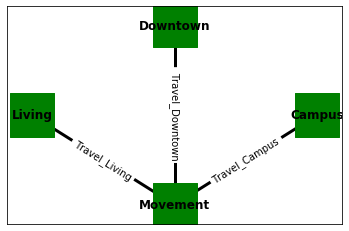

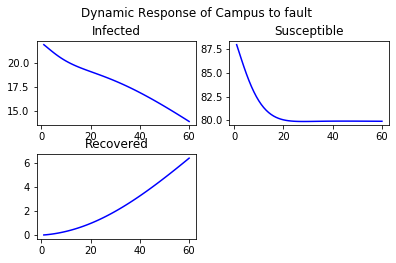

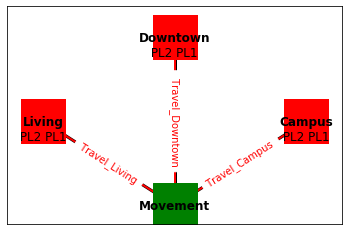

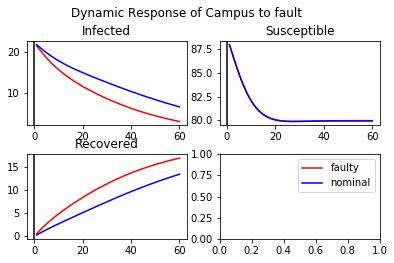

In [41]:
import sys
sys.path.append('../')
import pandas as pd
import faultprop as fp
import resultproc as rp
import csv
#from disease_model import *

x0 = np.array([2,3,5,10,0.15,2])

dm1 = DiseaseModel(x0)
    
    
    

rp.show_graph(dm1.graph)

endresults, resgraph, mdlhist_nom = fp.run_nominal(dm1)

rp.plot_mdlhist(mdlhist_nom, fxnflows=['Campus'])

normal_state_table = rp.make_histtable(mdlhist_nom)
normal_state_table.to_csv('normal_state_table.csv')
# print(normal_state_table)

# rp.plot_mdlhist(mdlhist)

endresults, resgraph, mdlhist_pl1 = fp.run_one_fault(dm1,'Campus','PL1', time=1)
PL1_state_table = rp.make_histtable(mdlhist_pl1)
# print(PL1_state_table)
rp.show_graph(resgraph)
rp.plot_mdlhist(mdlhist_pl1, fxnflows=['Campus'])



In [73]:
endresults['classification']

{'rate': 1,
 'cost': 1,
 'expected cost': 1,
 'total number of medical staff': 6.0,
 'total recovery people': 60.95717215159847}

In [74]:
dict= endresults['classification']
Imax=dict['total number of medical staff']
Nm=dict['total recovery people']
print(Imax, Nm)

6.0 60.95717215159847


In [42]:
H=500
E=50
T=50 # equal to  total time
Em=80
Tm=8
def cost(x):
    dm1 = DiseaseModel(x0)
    endresults, resgraph, mdlhist_pl1 = fp.run_nominal(dm1)
#     endresults, resgraph, mdlhist_pl1 = fp.run_one_fault(dm1,'Campus','PL1', time=1)
    dict= endresults['classification']
    Imax=dict['total recovery people']
    Nm=dict['total number of medical staff']
    return Imax*H + (10-x0[0])*300*E*T+ Nm*Em*Tm*T

x0 = np.array([2,3,5,4,0.3,10])
res = minimize(cost, x0, method='nelder-mead',
options={'xatol': 1e-8, 'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: 6299105.320589
         Iterations: 27
         Function evaluations: 215
[ 2.   3.   5.   4.   0.3 10. ]


In [9]:
from scipy.optimize import differential_evolution
import numpy as np
# def ackley(x):
    
#     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
#     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
#     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
# bounds = [(-5, 5), (-5, 5)]
# result = differential_evolution(ackley, bounds)
# result.x, result.fun
H=500
E=50
T=50 # equal to  total time
Em=80
Tm=8
def ackley(x):
    x0 = np.array([x[0],x[1],x[2],x[3],x[4],x[5]])
    dm1 = DiseaseModel(x0)
    try:
        endresults, resgraph, mdlhist_pl1 = fp.run_nominal(dm1)
        Imax= endresults['classification']['total recovery people']
        Nm=endresults['classification']['total number of medical staff']
        return Imax*H + (10-x0[0])* 300 * E*T+ Nm*Em*Tm*T
    except:
        return 10000000000
bounds = [(0, 2), (0, 2),(0, 2),(0, 2),(0, 2),(0, 2)]
result = differential_evolution(ackley, bounds,maxiter=10)
result.x, result.fun

C:\Users\zhang\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\zhang\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\zhang\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\zhang\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


(array([1.95219242, 0.05521719, 0.05615843, 0.00234217, 0.00534642,
        1.06071853]), -209213752.3056123)

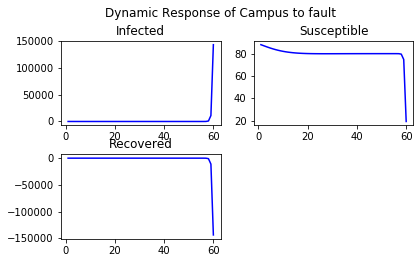

In [12]:
x0 = np.array([2,2,5,2,0.15,1])
dm1 = DiseaseModel(result.x)
endresults, resgraph, mdlhist_pl1 = fp.run_nominal(dm1)
endresults['classification']
#x0 = np.array([x[0],x[1],x[2],x[3],x[4],x[5]])
rp.plot_mdlhist(mdlhist_pl1, fxnflows=['Campus'])

In [121]:
import numpy as np
from scipy.optimize import minimize

H=500
E=50
T=50 # equal to  total time
Em=80
Tm=8
cost= Imax*H + (10-x0[0])*300*E*T+ Nm*Em*Tm*T

def re(x):
# """The Rosenbrock function"""
#     return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
    
    return x**2

# 
x0 = np.array([2])
res = minimize(re , x0, method='nelder-mead',
options={'xatol': 1e-8, 'disp': True})

print(res.x)



Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 64
[-1.77635684e-15]


In [103]:
import scipy.optimize as optimize

fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2
res = optimize.minimize(fun, (2, 0), method='SLSQP', tol=1e-10)
print(res.x)

[1.  2.5]


In [52]:
dm1.fxns['Campus'].n

2.0

In [46]:
# type(PL1_state_table)
# PL1_state_table.to_csv('PL1_state_table.csv')
# normal_state_table.to_csv('normal_state_table.csv')

In [122]:
import numpy as np
from scipy.optimize import minimize

def rosen(x):
# """The Rosenbrock function"""
#     return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
    return x**2
x0 = np.array([-1])
res = minimize(rosen, x0, method='nelder-mead',
options={'xatol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 62
[8.8817842e-16]


In [123]:
import numpy as np
x0 = np.array([2,3,5,6,7,10])
# for i in x0:
#     print(i)
print(x0[5])

10
